Sentiment Analysis using TensorFlow Keras

SECTION 1: Prepare data, train and save the model

In [1]:
# clean up
! rm -rf ready
! rm -rf prepare
! rm -rf sorted_data_acl/

In [2]:
# download and extract data


# downloading the data
!wget https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz

# extract the downloaded data
!tar -xvf domain_sentiment_data.tar.gz

--2022-08-25 06:47:40--  https://www.cs.jhu.edu/~mdredze/datasets/sentiment/domain_sentiment_data.tar.gz
Resolving www.cs.jhu.edu (www.cs.jhu.edu)... 128.220.13.64
Connecting to www.cs.jhu.edu (www.cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30586147 (29M) [application/x-gzip]
Saving to: ‘domain_sentiment_data.tar.gz’

domain_sentiment_da 100%[===================>]  29.17M  49.2MB/s    in 0.6s    

2022-08-25 06:47:41 (49.2 MB/s) - ‘domain_sentiment_data.tar.gz’ saved [30586147/30586147]

sorted_data_acl/dvd/negative.review
sorted_data_acl/dvd/unlabeled.review
sorted_data_acl/dvd/positive.review
sorted_data_acl/kitchen_&_housewares/negative.review
sorted_data_acl/kitchen_&_housewares/unlabeled.review
sorted_data_acl/kitchen_&_housewares/positive.review
sorted_data_acl/books/negative.review
sorted_data_acl/books/positive.review
sorted_data_acl/electronics/negative.review
sorted_data_acl/electronics/unlabeled.review
sorted_data_acl/

In [3]:
# create parsed directories
! mkdir -p prepare/labeled
! mkdir -p prepare/unlabeled
! mkdir -p ready

# add <root> tag to extracted data to prepare for parsing

# DVD
! { echo '<root>'; cat sorted_data_acl/dvd/negative.review; echo '</root>'; } > prepare/labeled/dvd_negative.xml
! { echo '<root>'; cat sorted_data_acl/dvd/positive.review; echo '</root>'; } > prepare/labeled/dvd_positive.xml

# Kitchen
! { echo '<root>'; cat sorted_data_acl/"kitchen_&_housewares"/negative.review; echo '</root>'; } > prepare/labeled/kitchen_negative.xml
! { echo '<root>'; cat sorted_data_acl/"kitchen_&_housewares"/positive.review; echo '</root>'; } > prepare/labeled/kitchen_positive.xml

# books
! { echo '<root>'; cat sorted_data_acl/books/negative.review; echo '</root>'; } > prepare/labeled/books_negative.xml
! { echo '<root>'; cat sorted_data_acl/books/positive.review; echo '</root>'; } > prepare/labeled/books_positive.xml

# electronics
! { echo '<root>'; cat sorted_data_acl/electronics/negative.review; echo '</root>'; } > prepare/labeled/electronics_negative.xml
! { echo '<root>'; cat sorted_data_acl/electronics/positive.review; echo '</root>'; } > prepare/labeled/electronics_positive.xml


# unlabeled data
! { echo '<root>'; cat sorted_data_acl/dvd/unlabeled.review; echo '</root>'; } > prepare/unlabeled/dvd_unlabeled.xml
! { echo '<root>'; cat sorted_data_acl/"kitchen_&_housewares"/unlabeled.review; echo '</root>'; } > prepare/unlabeled/kitchen_unlabeled.xml
! { echo '<root>'; cat sorted_data_acl/electronics/unlabeled.review; echo '</root>'; } > prepare/unlabeled/electronics_unlabeled.xml


In [4]:
import xml.etree.ElementTree as ET
from lxml import etree
import csv


class DataParser:
  """Data parser class to parse xml and dump to csv"""
  
  # base directory where prepared data exists for parsing
  base_dir = './prepare/labeled'


  # target is 1 for positive and 0 for negative
  fields = ['product_name', 'product_type', 'rating', 'title', 'review_text', 'target']

  # product types
  product_types = ['books', 'dvd', 'electronics', 'kitchen']

  # review types
  review_types = ['positive', 'negative']

  def __init__(self):
    pass


  def parse_and_dump(self):
    # parse and dump books
    self.parser()



  def parser(self):
    # iterate through different product and review types
    for product in self.product_types:
        data = self.parse_xml(product)
        self.csv_exporter(product, data)
        

  def parse_xml(self, product):
      parsed_reviews = []
      parser = etree.XMLParser(recover=True)
      for review_type in self.review_types:
        mytree = ET.parse(f'{self.base_dir}/{product}_{review_type}.xml', parser=parser)
        myroot = mytree.getroot()
        for e in myroot:
          data = {}
          for x in e:
            # add only required fields
            if x.tag in self.fields:
              data[x.tag] = str(x.text).strip()
            if review_type == 'positive':
              data['target'] = 1
            else:
              data['target'] = 0
          parsed_reviews.append(data)
      return parsed_reviews

  
  def csv_exporter(self, product, data):
    with open(f"ready/{product}.csv", 'w') as csvFile:
          wr = csv.DictWriter(csvFile, fieldnames=self.fields)
          wr.writeheader()
          for ele in data:
              wr.writerow(ele)


  

In [5]:
# parse and dump data in './ready' directory

dp = DataParser()
dp.parse_and_dump()

In [6]:
# combine all ready data in a single file
books = 'ready/books.csv'
dvd = 'ready/dvd.csv'
electronics = 'ready/electronics.csv'
kitchen = 'ready/kitchen.csv'

In [7]:
# load data for model training


import pandas as pd

# set this option on pd to print readable df
pd.set_option('expand_frame_repr', False)


print("*** Merging multiple csv files into a single pandas dataframe ***")
df = pd.concat(map(pd.read_csv, [books, dvd, electronics, kitchen ]), ignore_index=True)
print(df)

*** Merging multiple csv files into a single pandas dataframe ***
                                           product_name         product_type  rating                                              title                                        review_text  target
0                       Sphere: Books: Michael Crichton                books     5.0                    One of the best Crichton novels  Sphere by Michael Crichton is an excellant nov...       1
1     Healing from the Heart: A Leading Surgeon Comb...                books     4.0                         The Medicine of the Future  Dr. Oz is an accomplished heart surgeon in the...       1
2     Mythology: DC Comics Art of Alex Ross 2007 Cal...                books     5.0                                         Beautiful!  The most gorgeous artwork in comic books. Cont...       1
3     Pegasus Descending: A Dave Robicheaux Novel (D...                books     4.0                           For lovers of Robicheaux  This book is for 

In [ ]:
# train tensorflow model

In [8]:
import tensorflow as tf
import tensorflow_hub as hub


labeled_data = df[['target', 'review_text']]
labeled_data.head()

,target,review_text
0,1,Sphere by Michael Crichton is an excellant nov...
1,1,Dr. Oz is an accomplished heart surgeon in the...
2,1,The most gorgeous artwork in comic books. Cont...
3,1,This book is for lovers of Robicheaux. His de...
4,1,This is going to be a short and sweet review b...


In [9]:
# The dataset description says there is a neutral label but there are no neutral labels in the dataset
print('Negative Reviews:',len(labeled_data[labeled_data['target']==0]))
print('Positive Reviews:',len(labeled_data[labeled_data['target']==1]))

Negative Reviews: 4000
Positive Reviews: 4000


In [10]:
# create random train dataframe, with 80% of the data, test set with the remaining 20%
train = labeled_data.sample(frac=0.8) 
test = labeled_data.drop(train.index)

# turn columns into numpy arrays to use as inputs for training
train_examples, train_labels = train['review_text'].values, train['target'].values
test_examples, test_labels = test['review_text'].values, test['target'].values

In [11]:
# set up a directory for tensorflow hub downloads
import os
os.environ['TFHUB_CACHE_DIR'] = r'./tf_modules'

# we need to "tokenize" our inputs, convert our abstracts into numerical values
# use the tokenization model below, on tensorflow hub
model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

# example of tokenization of an abstract
hub_layer(train_examples[0:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.9894387 , -0.13895369,  0.20694721,  0.3476952 ,  0.08205836,
         0.03318814, -0.10100166, -0.02019348, -0.0884309 ,  0.4473196 ,
        -0.18280724, -0.28304207, -0.2574064 , -0.10029839, -0.16220862,
        -0.22716531, -0.04393406,  0.17203282, -0.13574089,  0.5695591 ,
         0.11139803,  0.17283437, -0.01684018, -0.09447124, -0.01493091,
        -0.22394672,  0.12286413,  0.04935203, -0.03629807, -0.14911467,
        -0.04904773,  0.07640599, -0.0572969 , -0.10991931,  0.2583145 ,
        -0.02208538, -0.03613434, -0.22565712,  0.0671861 ,  0.29124308,
        -0.02639124, -0.19714808, -0.26158562, -0.27005517,  0.12638772,
         0.20861793,  0.1279293 ,  0.20801377,  0.10516114,  0.05492086,
         0.09950738, -0.04922765,  0.21371669,  0.20757647, -0.21912375,
         0.02639686,  0.08509202, -0.27961087,  0.08701593,  0.06916428,
        -0.25699392,  0.15025622,  0.17221501, -0.11017065,  0.04174416,
 

In [12]:
# create a Sequential neural network
model = tf.keras.Sequential()
model.add(hub_layer) # add tokenization layer
model.add(tf.keras.layers.Dense(16, activation='relu')) # create hidden layer with 16 nodes
model.add(tf.keras.layers.Dense(8, activation='relu')) # create hidden layer with 8 nodes
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output layer, 1 node, sigmoid, for binary classification
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 124,644,897
Trainable params: 124,644,897
Non-trainable params: 0
_________________________________________________________________


In [13]:
# compile model, designed for binary classification
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [14]:
# set aside some of the example datapoints for validation during training
x_val = train_examples[:1000]
partial_x_train = train_examples[1000:]

y_val = train_labels[:1000]
partial_y_train = train_labels[1000:]

print(len(x_val), len(partial_x_train))

1000 5400


In [15]:
# train the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


85/85 [==============================] - 122s 1s/step - loss: 0.6480 - accuracy: 0.6417 - val_loss: 0.5252 - val_accuracy: 0.7770
Epoch 2/5
85/85 [==============================] - 114s 1s/step - loss: 0.3409 - accuracy: 0.8731 - val_loss: 0.3992 - val_accuracy: 0.8280
Epoch 3/5
85/85 [==============================] - 115s 1s/step - loss: 0.1261 - accuracy: 0.9628 - val_loss: 0.4394 - val_accuracy: 0.8130
Epoch 4/5
85/85 [==============================] - 114s 1s/step - loss: 0.0512 - accuracy: 0.9898 - val_loss: 0.5036 - val_accuracy: 0.8090
Epoch 5/5
85/85 [==============================] - 115s 1s/step - loss: 0.0227 - accuracy: 0.9965 - val_loss: 0.5860 - val_accuracy: 0.8080


In [16]:
# evaluate performance on test set
results = model.evaluate(test_examples, test_labels)
print(results)

50/50 [==============================] - 8s 166ms/step - loss: 0.5515 - accuracy: 0.8188
[0.5514793992042542, 0.8187500238418579]


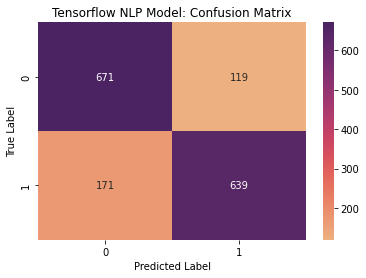

In [17]:
# visualize perfomance with a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = (model.predict(test_examples) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(test_labels, predictions)

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot=True, fmt="d", ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()


In [18]:
## save our model for future use, so we don't have to retrain each time
model.save(r'saved_model.h5')

SECTION 2: Test the saved model

In [19]:
loaded_model = tf.keras.models.load_model(r'saved_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})


In [ ]:
input_text = input('Enter text to do analysis on?\n')

In [ ]:
prediction = model.predict([input_text])
print(prediction)

In [ ]:
tensor_flow = (prediction > 0.5).astype("int32")[0][0]

In [ ]:
if tensor_flow == 1:
      tensor_flow = 'positive'
else:
      tensor_flow = 'negative'
print(tensor_flow)

SECTION 3: Setup and serve the REST API

In [20]:
# expose rest endpoint
!pip install flask
!pip install flask_cors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import flask
from IPython import get_ipython

In [22]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2022-08-25 07:00:30--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 52.202.168.65, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  57.4MB/s    in 0.2s    

2022-08-25 07:00:30 (57.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [23]:
! ./ngrok authtoken	2DfR51VrEBPD7k0VZMRUBkUmuOY_48MWz448eRyaqqbDAuqfV

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [30]:
get_ipython().system_raw('python3 app.py &')

In [34]:
get_ipython().system_raw('./ngrok http 5000 &')

 Copy the output of the following curl request into the base_url variable (line 48) in the frontend

In [35]:
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://f41c-34-73-127-102.ngrok.io


In [31]:
! python3 app.py

2022-08-25 07:20:51.690823: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-25 07:20:51.837262: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 498570752 exceeds 10% of free system memory.
2022-08-25 07:20:58.236659: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 498570752 exceeds 10% of free system memory.
2022-08-25 07:20:58.332091: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 498570752 exceeds 10% of free system memory.
 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
Traceback (most recent call last):
  File "app.py", line 51, in <module>
    app.run(host='0.0.0.0', port=5000)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 990, in run
    run_simple(host, port, self, **options)
  File "/usr/local/lib/python3.7/dist-packages/werk

In [32]:
! curl  http://localhost:5000/

Welcome to Golab REST API

To restart server, first check PID of the python3 app.py and ./ngrok http 5000 processes

In [ ]:
! ps -eaf 

In [ ]:
# Kill those processes using their PID
! kill -9 1048 1053
get_ipython().system_raw('python3 app.py &')
get_ipython().system_raw('./ngrok http 5000 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
! python3 app.py

# If app.py is not present in project root directory (inside content folder on the machine), create new file named app.py and copy the following code into it.

In [ ]:
from flask import Flask, make_response, jsonify, request
import tensorflow as tf
import tensorflow_hub as hub
from flask_cors import CORS


app = Flask(__name__)
CORS(app)

loaded_model = tf.keras.models.load_model(r'saved_model\reviews_model.h5', custom_objects={'KerasLayer': hub.KerasLayer})


@app.route('/')
def index():
    return "Welcome to Golab REST API"



@app.route('/api/analyse', methods=['POST'])
def analyse():
    data = request.get_json()
    resp = {}
    

    resp.update({"length": len(data['content'])})
    resp.update({"content": data['content']})
    
    # add model here
    prediction = loaded_model.predict([data['content']])
    prediction = prediction[0][0].astype("float")
    prediction = round(prediction, 2)
    resp.update({"positive": prediction})
    resp.update({"negative": round(1 - prediction, 2)})
    resp.update({"prediction": prediction})
    if prediction < 0.4:
      tensor_flow = 'negative'
    elif prediction > 0.6:
      tensor_flow = 'positive'
    else:
      tensor_flow = 'neutral'
    
    #this value is the thresh hold value beyound this we can determine if the sentiment is positive or not
    resp.update({"threshold": 0.5})

    resp.update({"overall": tensor_flow})
    print(resp)
    return jsonify(resp)
    

if __name__ == '__main__':
      app.run(host='0.0.0.0', port=5000)